# Analise de Research Questions

## Deteccao de Code Smells com Sistema Multi-Agentes baseado em LLM

**Comparacao entre modelos:** Claude Sonnet 4.5, GPT-4o-mini, DeepSeek V3.2

### Research Questions:
- **RQ1:** Qual a eficacia do sistema multi-agentes na deteccao de code smells?
- **RQ2:** Qual o impacto da qualidade dos prompts na performance da deteccao?
- **RQ3:** Como diferentes modelos LLM se comparam na deteccao de code smells?
- **RQ4:** Qual a performance individual de cada agente especializado?
- **RQ5:** Qual o custo-beneficio operacional de cada modelo LLM?

In [1]:
import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11
BASE_DIR = Path().resolve().parent
RESULTS_DIR = BASE_DIR / "results"
GT_DIR = BASE_DIR / "dataset" / "ground_truth"
FIGURES_DIR = RESULTS_DIR / "figures"
FIGURES_DIR.mkdir(exist_ok=True)
print(f"Diretorio base: {BASE_DIR}")

Diretorio base: /home/luis-chaves/Área de trabalho/tcc/multi-agent-smell-detector


## 1. Carregar Dados

In [2]:
gt = pd.read_csv(GT_DIR / "implementation_smells_manual_filtered.csv")
with open(
    RESULTS_DIR / "anthropic" / "claude-sonnet-4.5" / "results_complete_prompts.json"
) as f:
    claude_complete = pd.DataFrame(json.load(f))
with open(
    RESULTS_DIR
    / "anthropic"
    / "claude-sonnet-4.5"
    / "token_usage_complete_prompts.json"
) as f:
    tokens_claude = json.load(f)
claude_simple = pd.read_csv(
    RESULTS_DIR / "anthropic" / "claude-sonnet-4.5" / "results_simple_prompt.csv"
)
with open(
    RESULTS_DIR / "openai" / "gpt-4o-mini" / "results_complete_prompts.json"
) as f:
    gpt_complete = pd.DataFrame(json.load(f))
with open(
    RESULTS_DIR / "openai" / "gpt-4o-mini" / "token_usage_complete_prompts.json"
) as f:
    tokens_gpt = json.load(f)
with open(
    RESULTS_DIR / "deepseek" / "deepseek-v3.2" / "results_complete_prompts.json"
) as f:
    deepseek_complete = pd.DataFrame(json.load(f))
with open(
    RESULTS_DIR / "deepseek" / "deepseek-v3.2" / "token_usage_complete_prompts.json"
) as f:
    tokens_deepseek = json.load(f)
print(f"Ground Truth: {gt['Count'].sum()} smells")
print(f"Claude: {len(claude_complete)} complete, {len(claude_simple)} simple")
print(f"GPT-4o-mini: {len(gpt_complete)}")
print(f"DeepSeek: {len(deepseek_complete)}")

Ground Truth: 411 smells
Claude: 500 complete, 563 simple
GPT-4o-mini: 283
DeepSeek: 211


## 2. Preparacao dos Dados

In [3]:
FILE_TO_MODULE = {
    "_codespell.py": "_codespell",
    "_spellchecker.py": "_spellchecker",
    "test_basic.py": "test_basic",
    "test_dictionary.py": "test_dictionary",
    "addr.py": "addr",
    "colorized.py": "colorized",
    "common.py": "common",
    "log.py": "log",
    "settings.py": "settings",
    "update.py": "update",
    "alienvault.py": "alienvault",
    "badips.py": "badips",
    "dataplane.py": "dataplane",
    "torproject.py": "torproject",
    "ff_ippo_store_experience.py": "ff_ippo_store_experience",
    "ff_ippo.py": "ff_ippo",
    "ff_mappo.py": "ff_mappo",
    "rec_ippo.py": "rec_ippo",
    "ff_isac.py": "ff_isac",
    "checkpointing.py": "checkpointing",
}
SMELL_NORMALIZE = {
    "complex method": "Complex Method",
    "complex conditional": "Complex Conditional",
    "long method": "Long Method",
    "long parameter list": "Long Parameter List",
    "long statement": "Long Statement",
    "long identifier": "Long Identifier",
    "magic number": "Magic Number",
    "empty catch block": "Empty Catch Block",
    "missing default": "Missing Default",
    "long lambda function": "Long Lambda Function",
    "long message chain": "Long Message Chain",
}


def extract_filename(path):
    if pd.isna(path):
        return ""
    return Path(str(path)).name


def process_csv_results(df):
    df = df.copy()
    df["Module"] = df["File"].apply(
        lambda x: FILE_TO_MODULE.get(x, x.replace(".py", "") if pd.notna(x) else "")
    )
    df["Smell_norm"] = df["Code_Smell"].str.lower().str.strip()
    df["Smell"] = df["Smell_norm"].apply(
        lambda x: SMELL_NORMALIZE.get(x, x.title()) if pd.notna(x) else ""
    )
    return df.groupby(["Module", "Smell"]).size().reset_index(name="Count")


def process_json_results(df):
    df = df.copy()
    df["Filename"] = df["File"].apply(extract_filename)
    df["Module"] = df["Filename"].apply(
        lambda x: FILE_TO_MODULE.get(x, x.replace(".py", "") if pd.notna(x) else "")
    )
    df["Smell_norm"] = df["Smell"].str.lower().str.strip()
    df["Smell_clean"] = df["Smell_norm"].apply(
        lambda x: SMELL_NORMALIZE.get(x, x.title()) if pd.notna(x) else ""
    )
    counts = df.groupby(["Module", "Smell_clean"]).size().reset_index(name="Count")
    counts.columns = ["Module", "Smell", "Count"]
    return counts


sys_claude_complete = process_json_results(claude_complete)
sys_claude_simple = process_csv_results(claude_simple)
sys_gpt = process_json_results(gpt_complete)
sys_deepseek = process_json_results(deepseek_complete)
print(
    f"Claude complete: {sys_claude_complete['Count'].sum()}, simple: {sys_claude_simple['Count'].sum()}"
)
print(f"GPT: {sys_gpt['Count'].sum()}, DeepSeek: {sys_deepseek['Count'].sum()}")

Claude complete: 500, simple: 563
GPT: 283, DeepSeek: 211


## 3. Funcao de Validacao

In [4]:
def validate_by_presence(gt_df, sys_df, label="Sistema"):
    all_modules = set(gt_df["Module"].unique()) | set(sys_df["Module"].unique())
    all_smells = set(gt_df["Smell"].unique()) | set(sys_df["Smell"].unique())
    gt_dict = {(r["Module"], r["Smell"]): r["Count"] for _, r in gt_df.iterrows()}
    sys_dict = {(r["Module"], r["Smell"]): r["Count"] for _, r in sys_df.iterrows()}
    results = []
    total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0
    for module in all_modules:
        for smell in all_smells:
            gt_count = gt_dict.get((module, smell), 0)
            sys_count = sys_dict.get((module, smell), 0)
            gt_present, sys_present = gt_count > 0, sys_count > 0
            if gt_present and sys_present:
                total_tp += 1
            elif not gt_present and sys_present:
                total_fp += 1
            elif gt_present and not sys_present:
                total_fn += 1
            else:
                total_tn += 1
            if gt_present or sys_present:
                results.append(
                    {
                        "Module": module,
                        "Smell": smell,
                        "GT": gt_count,
                        "SYS": sys_count,
                        "TP": 1 if (gt_present and sys_present) else 0,
                        "FP": 1 if (not gt_present and sys_present) else 0,
                        "FN": 1 if (gt_present and not sys_present) else 0,
                    }
                )
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = (
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    )
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
    results_df = pd.DataFrame(results)
    smell_metrics = (
        results_df.groupby("Smell")
        .agg({"GT": "sum", "SYS": "sum", "TP": "sum", "FP": "sum", "FN": "sum"})
        .reset_index()
    )
    smell_metrics["Precision"] = smell_metrics.apply(
        lambda r: r["TP"] / (r["TP"] + r["FP"]) if (r["TP"] + r["FP"]) > 0 else 0,
        axis=1,
    )
    smell_metrics["Recall"] = smell_metrics.apply(
        lambda r: r["TP"] / (r["TP"] + r["FN"]) if (r["TP"] + r["FN"]) > 0 else 0,
        axis=1,
    )
    smell_metrics["F1"] = smell_metrics.apply(
        lambda r: 2 * r["Precision"] * r["Recall"] / (r["Precision"] + r["Recall"])
        if (r["Precision"] + r["Recall"]) > 0
        else 0,
        axis=1,
    )
    return {
        "label": label,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "tp": total_tp,
        "fp": total_fp,
        "fn": total_fn,
        "tn": total_tn,
        "gt_total": gt_df["Count"].sum(),
        "sys_total": sys_df["Count"].sum(),
        "smell_metrics": smell_metrics,
        "details": results_df,
    }

## RQ1 - Eficacia Geral

In [5]:
metrics_claude = validate_by_presence(gt, sys_claude_complete, "Claude Sonnet 4.5")
print("=" * 70)
print("RQ1 - EFICACIA GERAL (CLAUDE SONNET 4.5)")
print("=" * 70)
print(
    f"\nTotal GT: {metrics_claude['gt_total']} | Sistema: {metrics_claude['sys_total']}"
)
print(
    f"TP: {metrics_claude['tp']} | FP: {metrics_claude['fp']} | FN: {metrics_claude['fn']} | TN: {metrics_claude['tn']}"
)
print("-" * 40)
print(f"Precision: {metrics_claude['precision'] * 100:.2f}%")
print(f"Recall: {metrics_claude['recall'] * 100:.2f}%")
print(f"F1-Score: {metrics_claude['f1'] * 100:.2f}%")
print(f"Accuracy: {metrics_claude['accuracy'] * 100:.2f}%")

RQ1 - EFICACIA GERAL (CLAUDE SONNET 4.5)

Total GT: 411 | Sistema: 500
TP: 57 | FP: 59 | FN: 12 | TN: 81
----------------------------------------
Precision: 49.14%
Recall: 82.61%
F1-Score: 61.62%
Accuracy: 66.03%


## RQ2 - Impacto dos Prompts

In [6]:
metrics_claude_simple = validate_by_presence(gt, sys_claude_simple, "Claude (Simple)")
print("=" * 70)
print("RQ2 - IMPACTO DOS PROMPTS")
print("=" * 70)
print(f"\n{'Metrica':<15} {'Elaborados':>12} {'Simples':>12} {'Diff':>12}")
print("-" * 55)
print(
    f"{'Precision':<15} {metrics_claude['precision'] * 100:>11.2f}% {metrics_claude_simple['precision'] * 100:>11.2f}% {(metrics_claude['precision'] - metrics_claude_simple['precision']) * 100:>+11.2f}pp"
)
print(
    f"{'Recall':<15} {metrics_claude['recall'] * 100:>11.2f}% {metrics_claude_simple['recall'] * 100:>11.2f}% {(metrics_claude['recall'] - metrics_claude_simple['recall']) * 100:>+11.2f}pp"
)
print(
    f"{'F1-Score':<15} {metrics_claude['f1'] * 100:>11.2f}% {metrics_claude_simple['f1'] * 100:>11.2f}% {(metrics_claude['f1'] - metrics_claude_simple['f1']) * 100:>+11.2f}pp"
)
contingency = [
    [metrics_claude["tp"], metrics_claude["fp"]],
    [metrics_claude_simple["tp"], metrics_claude_simple["fp"]],
]
chi2, p_value, _, _ = stats.chi2_contingency(contingency)
print(f"\nChi2: {chi2:.4f}, p-valor: {p_value:.4f}")
print(f"Significativo (p<0.05): {'SIM' if p_value < 0.05 else 'NAO'}")

RQ2 - IMPACTO DOS PROMPTS

Metrica           Elaborados      Simples         Diff
-------------------------------------------------------
Precision             49.14%       44.72%       +4.42pp
Recall                82.61%       79.71%       +2.90pp
F1-Score              61.62%       57.29%       +4.33pp

Chi2: 0.3081, p-valor: 0.5788
Significativo (p<0.05): NAO


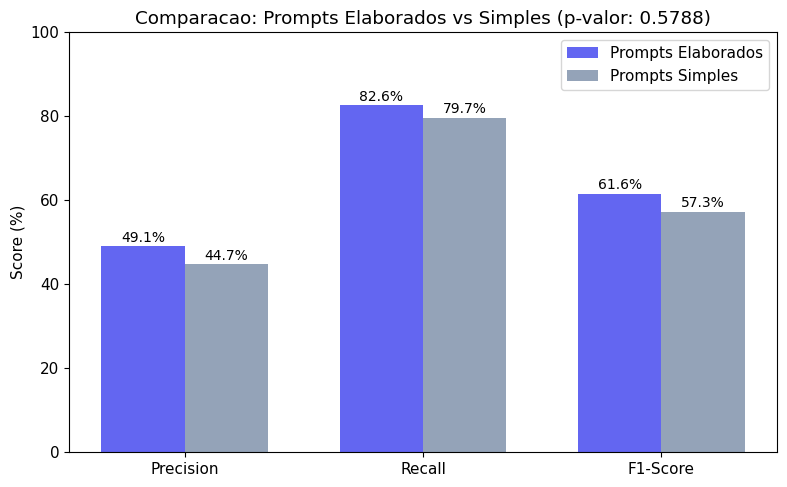

Salvo: fig4_prompt_impact.pdf/png


In [7]:
# Grafico RQ2 - Impacto dos Prompts
fig, ax = plt.subplots(figsize=(8, 5))

metrics_names = ["Precision", "Recall", "F1-Score"]
elaborados = [
    metrics_claude["precision"],
    metrics_claude["recall"],
    metrics_claude["f1"],
]
simples = [
    metrics_claude_simple["precision"],
    metrics_claude_simple["recall"],
    metrics_claude_simple["f1"],
]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax.bar(
    x - width / 2,
    [v * 100 for v in elaborados],
    width,
    label="Prompts Elaborados",
    color="#6366f1",
)
bars2 = ax.bar(
    x + width / 2,
    [v * 100 for v in simples],
    width,
    label="Prompts Simples",
    color="#94a3b8",
)

ax.set_ylabel("Score (%)")
ax.set_title(f"Comparacao: Prompts Elaborados vs Simples (p-valor: {p_value:.4f})")
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.set_ylim(0, 100)

# Adicionar valores nas barras
for bar in bars1:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{bar.get_height():.1f}%",
        ha="center",
        fontsize=10,
    )
for bar in bars2:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{bar.get_height():.1f}%",
        ha="center",
        fontsize=10,
    )

plt.tight_layout()
plt.savefig(FIGURES_DIR / "fig4_prompt_impact.pdf", bbox_inches="tight", dpi=300)
plt.savefig(FIGURES_DIR / "fig4_prompt_impact.png", bbox_inches="tight", dpi=300)
plt.show()
print("Salvo: fig4_prompt_impact.pdf/png")

## RQ3 - Comparacao entre LLMs

In [8]:
metrics_gpt = validate_by_presence(gt, sys_gpt, "GPT-4o-mini")
metrics_deepseek = validate_by_presence(gt, sys_deepseek, "DeepSeek V3.2")
print("=" * 70)
print("RQ3 - COMPARACAO ENTRE MODELOS LLM")
print("=" * 70)
print(f"\n{'Modelo':<20} {'Precision':>12} {'Recall':>12} {'F1':>12} {'Accuracy':>12}")
print("-" * 70)
for m in [metrics_claude, metrics_gpt, metrics_deepseek]:
    print(
        f"{m['label']:<20} {m['precision'] * 100:>11.2f}% {m['recall'] * 100:>11.2f}% {m['f1'] * 100:>11.2f}% {m['accuracy'] * 100:>11.2f}%"
    )
print(
    f"\nDeteccoes: Claude={metrics_claude['sys_total']}, GPT={metrics_gpt['sys_total']}, DeepSeek={metrics_deepseek['sys_total']}, GT={metrics_claude['gt_total']}"
)

RQ3 - COMPARACAO ENTRE MODELOS LLM

Modelo                  Precision       Recall           F1     Accuracy
----------------------------------------------------------------------
Claude Sonnet 4.5          49.14%       82.61%       61.62%       66.03%
GPT-4o-mini                54.37%       81.16%       65.12%       72.73%
DeepSeek V3.2              71.70%       55.07%       62.30%       77.99%

Deteccoes: Claude=500, GPT=283, DeepSeek=211, GT=411


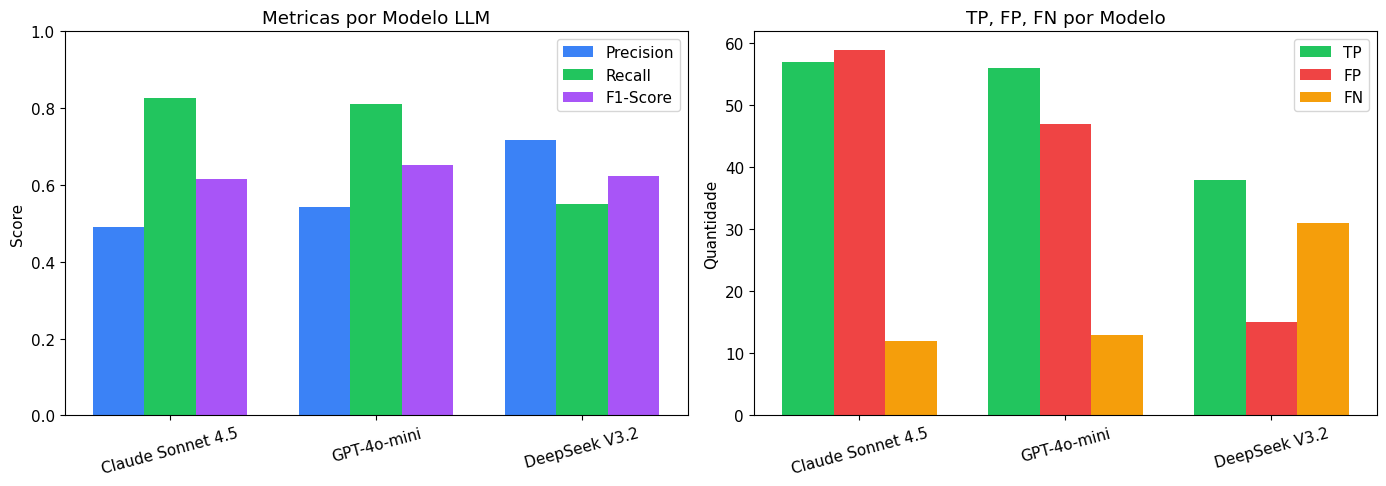

Salvo: fig1_llm_comparison.pdf/png


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
models = ["Claude Sonnet 4.5", "GPT-4o-mini", "DeepSeek V3.2"]
metrics_list = [metrics_claude, metrics_gpt, metrics_deepseek]
x = np.arange(len(models))
width = 0.25
axes[0].bar(
    x - width,
    [m["precision"] for m in metrics_list],
    width,
    label="Precision",
    color="#3b82f6",
)
axes[0].bar(
    x, [m["recall"] for m in metrics_list], width, label="Recall", color="#22c55e"
)
axes[0].bar(
    x + width, [m["f1"] for m in metrics_list], width, label="F1-Score", color="#a855f7"
)
axes[0].set_ylabel("Score")
axes[0].set_title("Metricas por Modelo LLM")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[1].bar(
    x - width, [m["tp"] for m in metrics_list], width, label="TP", color="#22c55e"
)
axes[1].bar(x, [m["fp"] for m in metrics_list], width, label="FP", color="#ef4444")
axes[1].bar(
    x + width, [m["fn"] for m in metrics_list], width, label="FN", color="#f59e0b"
)
axes[1].set_ylabel("Quantidade")
axes[1].set_title("TP, FP, FN por Modelo")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=15)
axes[1].legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "fig1_llm_comparison.pdf", bbox_inches="tight", dpi=300)
plt.savefig(FIGURES_DIR / "fig1_llm_comparison.png", bbox_inches="tight", dpi=300)
plt.show()
print("Salvo: fig1_llm_comparison.pdf/png")

## RQ4 - Performance dos Agentes por Modelo

In [10]:
print("=" * 90)
print("RQ4 - COMPARACAO DE AGENTES POR MODELO")
print("=" * 90)

smell_claude = metrics_claude["smell_metrics"].set_index("Smell")
smell_gpt = metrics_gpt["smell_metrics"].set_index("Smell")
smell_deepseek = metrics_deepseek["smell_metrics"].set_index("Smell")

all_smells = sorted(
    set(smell_claude.index) | set(smell_gpt.index) | set(smell_deepseek.index)
)

print(
    f"\n{'Code Smell':<25} {'Claude F1':>12} {'GPT F1':>12} {'DeepSeek F1':>12} {'Melhor':>15}"
)
print("-" * 80)

best_count = {"Claude": 0, "GPT": 0, "DeepSeek": 0}
comparison_data = []

for smell in all_smells:
    f1_c = smell_claude.loc[smell, "F1"] * 100 if smell in smell_claude.index else 0
    f1_g = smell_gpt.loc[smell, "F1"] * 100 if smell in smell_gpt.index else 0
    f1_d = smell_deepseek.loc[smell, "F1"] * 100 if smell in smell_deepseek.index else 0

    best = max(f1_c, f1_g, f1_d)
    if best == 0:
        best_model = "-"
    elif best == f1_c:
        best_model = "Claude"
        best_count["Claude"] += 1
    elif best == f1_g:
        best_model = "GPT"
        best_count["GPT"] += 1
    else:
        best_model = "DeepSeek"
        best_count["DeepSeek"] += 1

    comparison_data.append(
        {"Smell": smell, "Claude": f1_c, "GPT": f1_g, "DeepSeek": f1_d}
    )
    print(f"{smell:<25} {f1_c:>11.1f}% {f1_g:>11.1f}% {f1_d:>11.1f}% {best_model:>15}")

print("-" * 80)
print("\nMelhor modelo por agente:")
for model, count in sorted(best_count.items(), key=lambda x: -x[1]):
    print(f"  {model}: {count} agentes")

RQ4 - COMPARACAO DE AGENTES POR MODELO

Code Smell                   Claude F1       GPT F1  DeepSeek F1          Melhor
--------------------------------------------------------------------------------
Complex Conditional              66.7%        50.0%         0.0%          Claude
Complex Method                   23.5%        26.1%        18.2%             GPT
Empty Catch Block                80.0%        92.3%        80.0%             GPT
Long Identifier                  28.6%         0.0%         0.0%          Claude
Long Lambda Function             66.7%        70.6%        36.4%             GPT
Long Message Chain               22.2%         0.0%        33.3%        DeepSeek
Long Method                      83.3%        83.3%        70.6%          Claude
Long Parameter List              30.0%        45.5%        42.9%             GPT
Long Statement                   83.9%        89.7%        78.3%             GPT
Magic Number                     96.0%        91.7%        95.7%     

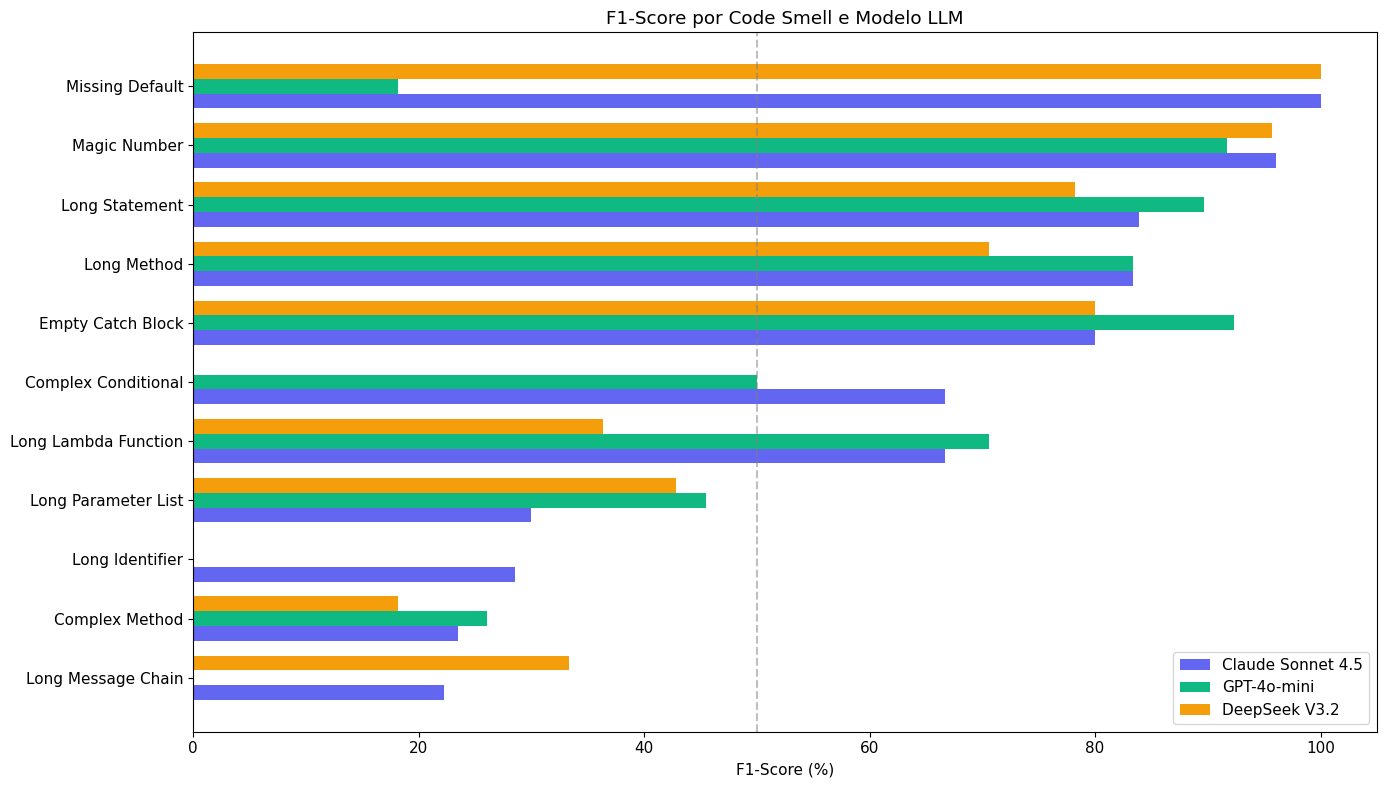

Salvo: fig2_f1_by_smell_comparison.pdf/png


In [11]:
# Grafico comparativo de F1 por smell
comp_df = (
    pd.DataFrame(comparison_data)
    .set_index("Smell")
    .sort_values("Claude", ascending=True)
)

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(comp_df))
width = 0.25

ax.barh(x - width, comp_df["Claude"], width, label="Claude Sonnet 4.5", color="#6366f1")
ax.barh(x, comp_df["GPT"], width, label="GPT-4o-mini", color="#10b981")
ax.barh(x + width, comp_df["DeepSeek"], width, label="DeepSeek V3.2", color="#f59e0b")

ax.set_yticks(x)
ax.set_yticklabels(comp_df.index)
ax.set_xlabel("F1-Score (%)")
ax.set_title("F1-Score por Code Smell e Modelo LLM")
ax.legend(loc="lower right")
ax.axvline(x=50, color="gray", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "fig2_f1_by_smell_comparison.pdf", bbox_inches="tight", dpi=300
)
plt.savefig(
    FIGURES_DIR / "fig2_f1_by_smell_comparison.png", bbox_inches="tight", dpi=300
)
plt.show()
print("Salvo: fig2_f1_by_smell_comparison.pdf/png")

## RQ5 - Custo-Beneficio

In [12]:
# Definir diretorios dos modelos
CLAUDE_DIR = RESULTS_DIR / 'anthropic' / 'claude-sonnet-4.5'
GPT_DIR = RESULTS_DIR / 'openai' / 'gpt-4o-mini'
DEEPSEEK_DIR = RESULTS_DIR / 'deepseek' / 'deepseek-v3.2'

# Carregar tempos de execucao por modelo
def load_execution_times(model_path):
    metrics_file = model_path / 'file_metrics_complete_prompts.json'
    if metrics_file.exists():
        with open(metrics_file) as f:
            metrics = json.load(f)
        return sum(m['execution_time_seconds'] for m in metrics)
    return 0

time_claude = load_execution_times(CLAUDE_DIR)
time_gpt = load_execution_times(GPT_DIR)
time_deepseek = load_execution_times(DEEPSEEK_DIR)

cost_claude = tokens_claude['total_cost_usd']
cost_gpt = tokens_gpt['total_cost_usd']
cost_deepseek = tokens_deepseek['total_cost_usd']

print("=" * 70)
print("RQ5 - EFICIENCIA OPERACIONAL")
print("=" * 70)
print()
print("TEMPO DE EXECUCAO:")
print(f"  Claude Sonnet 4.5: {time_claude:.1f}s ({time_claude/60:.1f} min)")
print(f"  GPT-4o-mini:       {time_gpt:.1f}s ({time_gpt/60:.1f} min)")
print(f"  DeepSeek V3.2:     {time_deepseek:.1f}s ({time_deepseek/60:.1f} min)")
print()
print("CUSTO:")
print(f"  Claude Sonnet 4.5: ${cost_claude:.4f}")
print(f"  GPT-4o-mini:       ${cost_gpt:.4f}")
print(f"  DeepSeek V3.2:     ${cost_deepseek:.4f}")


RQ5 - EFICIENCIA OPERACIONAL

TEMPO DE EXECUCAO:
  Claude Sonnet 4.5: 189.4s (3.2 min)
  GPT-4o-mini:       150.4s (2.5 min)
  DeepSeek V3.2:     453.6s (7.6 min)

CUSTO:
  Claude Sonnet 4.5: $5.7947
  GPT-4o-mini:       $0.2128
  DeepSeek V3.2:     $0.3016


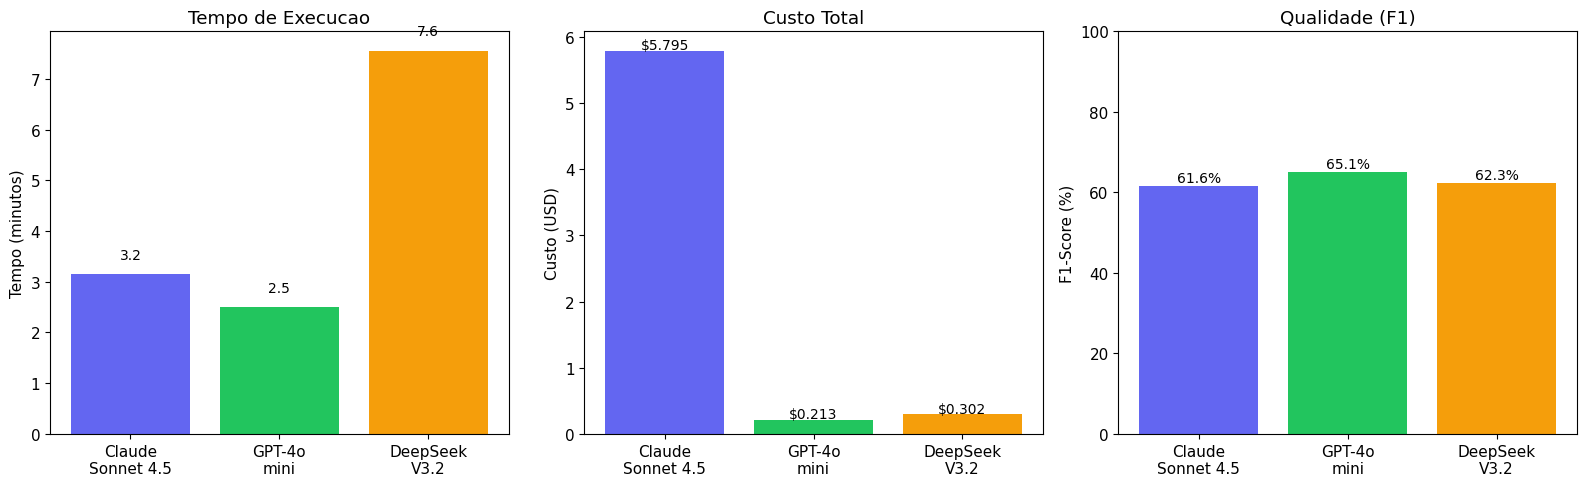

Salvo: fig5_efficiency_analysis.pdf/png


In [13]:
# Grafico RQ5 - Tempo e Custo por Modelo
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = ['Claude\nSonnet 4.5', 'GPT-4o\nmini', 'DeepSeek\nV3.2']
times = [time_claude/60, time_gpt/60, time_deepseek/60]  # em minutos
costs_vals = [cost_claude, cost_gpt, cost_deepseek]
f1_vals = [metrics_claude['f1']*100, metrics_gpt['f1']*100, metrics_deepseek['f1']*100]
colors = ['#6366f1', '#22c55e', '#f59e0b']

# Grafico 1: Tempo de execucao
bars1 = axes[0].bar(models, times, color=colors)
axes[0].set_ylabel('Tempo (minutos)')
axes[0].set_title('Tempo de Execucao')
for bar, t in zip(bars1, times):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{t:.1f}', ha='center', fontsize=10)

# Grafico 2: Custo
bars2 = axes[1].bar(models, costs_vals, color=colors)
axes[1].set_ylabel('Custo (USD)')
axes[1].set_title('Custo Total')
for bar, c in zip(bars2, costs_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'${c:.3f}', ha='center', fontsize=10)

# Grafico 3: F1-Score (para contexto)
bars3 = axes[2].bar(models, f1_vals, color=colors)
axes[2].set_ylabel('F1-Score (%)')
axes[2].set_title('Qualidade (F1)')
axes[2].set_ylim(0, 100)
for bar, f in zip(bars3, f1_vals):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{f:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig5_efficiency_analysis.pdf', bbox_inches='tight', dpi=300)
plt.savefig(FIGURES_DIR / 'fig5_efficiency_analysis.png', bbox_inches='tight', dpi=300)
plt.show()
print('Salvo: fig5_efficiency_analysis.pdf/png')


In [14]:
# Tabela de custo-beneficio
print()
print("=" * 90)
print("ANALISE CUSTO-BENEFICIO")
print("=" * 90)
print()
print(f"{'Modelo':<20} {'F1':<10} {'Custo':<12} {'Tempo':<12} {'F1/Custo':<15} {'F1/Tempo':<12}")
print("-" * 90)

model_names = ['Claude Sonnet 4.5', 'GPT-4o-mini', 'DeepSeek V3.2']
f1s = [metrics_claude['f1'], metrics_gpt['f1'], metrics_deepseek['f1']]
times_list = [time_claude, time_gpt, time_deepseek]
costs_list = [cost_claude, cost_gpt, cost_deepseek]

cost_benefit_data = []
for name, f1, cost, time in zip(model_names, f1s, costs_list, times_list):
    f1_cost = (f1 * 100) / cost if cost > 0 else 0
    f1_time = (f1 * 100) / (time / 60) if time > 0 else 0  # F1 por minuto
    print(f"{name:<20} {f1*100:>6.1f}%   ${cost:<10.4f} {time/60:>6.1f} min   {f1_cost:>10.1f}       {f1_time:>8.2f}")
    cost_benefit_data.append({'Modelo': name, 'F1/$1': f1_cost, 'F1/min': f1_time})

# Melhor custo-beneficio
best = max(cost_benefit_data, key=lambda x: x['F1/$1'])
print()
print(f"Melhor custo-beneficio: {best['Modelo']} (F1/$1 = {best['F1/$1']:.1f})")
print()
print("Interpretacao:")
print("  - F1/Custo: quanto maior, melhor custo-beneficio (F1 por dolar)")
print("  - F1/Tempo: quanto maior, mais rapido com boa qualidade (F1 por minuto)")



ANALISE CUSTO-BENEFICIO

Modelo               F1         Custo        Tempo        F1/Custo        F1/Tempo    
------------------------------------------------------------------------------------------
Claude Sonnet 4.5      61.6%   $5.7947        3.2 min         10.6          19.52
GPT-4o-mini            65.1%   $0.2128        2.5 min        306.0          25.97
DeepSeek V3.2          62.3%   $0.3016        7.6 min        206.5           8.24

Melhor custo-beneficio: GPT-4o-mini (F1/$1 = 306.0)

Interpretacao:
  - F1/Custo: quanto maior, melhor custo-beneficio (F1 por dolar)
  - F1/Tempo: quanto maior, mais rapido com boa qualidade (F1 por minuto)


## Resumo Executivo

In [15]:
print("=" * 70)
print("RESUMO EXECUTIVO")
print("=" * 70)
print(
    f"\nGround Truth: {gt['Count'].sum()} smells em {len(gt['Module'].unique())} modulos"
)
print(
    f"\nRQ1 - Eficacia (Claude): F1={metrics_claude['f1'] * 100:.2f}%, Precision={metrics_claude['precision'] * 100:.2f}%, Recall={metrics_claude['recall'] * 100:.2f}%"
)
print(
    f"RQ2 - Prompts: Elaborados F1={metrics_claude['f1'] * 100:.2f}% vs Simples F1={metrics_claude_simple['f1'] * 100:.2f}% (diff={(metrics_claude['f1'] - metrics_claude_simple['f1']) * 100:+.2f}pp)"
)
print(
    f"RQ3 - LLMs: Claude F1={metrics_claude['f1'] * 100:.1f}%, GPT F1={metrics_gpt['f1'] * 100:.1f}%, DeepSeek F1={metrics_deepseek['f1'] * 100:.1f}%"
)
print(
    f"RQ4 - Melhor por agente: Claude={best_count['Claude']}, GPT={best_count['GPT']}, DeepSeek={best_count['DeepSeek']}"
)
print(
    f"RQ5 - Custo: Melhor custo-beneficio = {best['Modelo']} (F1/$1 = {best['F1/$1']:.2f})"
)
print("=" * 70)

RESUMO EXECUTIVO

Ground Truth: 411 smells em 19 modulos

RQ1 - Eficacia (Claude): F1=61.62%, Precision=49.14%, Recall=82.61%
RQ2 - Prompts: Elaborados F1=61.62% vs Simples F1=57.29% (diff=+4.33pp)
RQ3 - LLMs: Claude F1=61.6%, GPT F1=65.1%, DeepSeek F1=62.3%
RQ4 - Melhor por agente: Claude=5, GPT=5, DeepSeek=1
RQ5 - Custo: Melhor custo-beneficio = GPT-4o-mini (F1/$1 = 306.00)
